In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
sys.path.append('../')

# Graph imports
import src.graph as graph
import src.logit_estimator as estimator
import src.utils as utils
import src.model_selection as model_selection
import src.gic as gic
import src.param_estimator as pe
import src.graph as graph
import src.model_selection as ms

# usual imports
import matplotlib.pyplot as plt
import pickle
import math
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import gaussian_kde
import numpy as np
import pandas as pd
import seaborn as sns
import gc
import random
import networkx as nx
from numpy import errstate

from IPython.display import display
from pyvis.network import Network
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
np.random.seed(42)
datasets = f'../data/connectomes/'
connectomes = sorted(os.listdir(datasets)) 
print(connectomes)

# Ensure the necessary directories exist
os.makedirs('../images/imgs_connectomes_spectra_kde/', exist_ok=True)

['c.elegans.herm_pharynx_1.graphml', 'c.elegans_neural.male_1.graphml', 'drosophila_medulla_1.graphml', 'kasthuri_graph_v4.graphml', 'mixed.species_brain_1.graphml', 'mouse_brain_1.graphml', 'mouse_retina_1.graphml', 'mouse_visual.cortex_1.graphml', 'mouse_visual.cortex_2.graphml', 'p.pacificus_neural.synaptic_1.graphml', 'p.pacificus_neural.synaptic_2.graphml', 'rattus.norvegicus_brain_1.graphml', 'rattus.norvegicus_brain_2.graphml', 'rattus.norvegicus_brain_3.graphml', 'rhesus_brain_1.graphml', 'rhesus_brain_2.graphml', 'rhesus_cerebral.cortex_1.graphml', 'rhesus_interareal.cortical.network_2.graphml']


In [4]:
def get_logit_graph(real_graph, d, n_iteration, warm_up, patience, dist_type='KL'):
   # Ensure real_graph is a NumPy array
   if isinstance(real_graph, nx.Graph):
       real_graph = nx.to_numpy_array(real_graph)
   
   # Estimation
   est = estimator.LogitRegEstimator(real_graph, d=d)
   features, labels = est.get_features_labels()
   result, params, pvalue = est.estimate_parameters(l1_wt=1, alpha=0, features=features, labels=labels)
   sigma = params[0]

   # Generation
   n = real_graph.shape[0]

   # TODO: improve the estimation of d
   # d=0

   params_dict = {
      "n": n,
      "d": d,
      "sigma": sigma,
      "n_iteration": n_iteration,
      "warm_up": warm_up
   }

   graph_model = graph.GraphModel(n=n, d=d, sigma=sigma)
   graphs, spec, spectrum_diffs, best_iteration = graph_model.populate_edges_spectrum(
       warm_up=warm_up,
       max_iterations=n_iteration,
       patience=patience,  # You may want to adjust this value
       real_graph=real_graph
   )

   # Add early stopping condition
   if len(spectrum_diffs) > 10000 and all(abs(spectrum_diffs[-1] - sd) < 1e-6 for sd in spectrum_diffs[-10000:]):
       print("Early stopping: No significant improvement in the last 1000 iterations.")
       best_iteration = len(spectrum_diffs) - 10000

   # Use the best graph found
   best_graph = graphs[best_iteration]
   # Calculate GIC for the best graph
   best_graph_nx = nx.from_numpy_array(best_graph)
   gic_value = gic.GraphInformationCriterion(
       graph=nx.from_numpy_array(real_graph),
       log_graph=best_graph_nx,
       model='LG',
       dist_type=dist_type # KL or L1 or L2
   ).calculate_gic()
   
   gic_values = [gic_value]
   return best_graph, sigma, gic_values, spectrum_diffs, best_iteration, graphs

def clean_and_convert(param):
    cleaned_param = ''.join(c for c in param if c.isdigit() or c == '.' or c == '-')
    return float(cleaned_param)

def plot_graphs_in_matrix(sim_graphs_dict, result_dict, global_title, save_path=None):
    num_graphs = len(sim_graphs_dict)
    cols = min(4, num_graphs)  # Limit to 4 columns max
    rows = math.ceil(num_graphs / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
    if rows == 1 and cols == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for ax, (name, G) in zip(axes, sim_graphs_dict.items()):
        # Use force-directed layout for better distribution of nodes
        pos = nx.spring_layout(G, k=0.5, iterations=50)

        # Normalize node sizes and reduce
        degrees = dict(G.degree())
        max_degree = max(degrees.values())
        min_degree = min(degrees.values())
        node_sizes = [((degrees[node] - min_degree) / (max_degree - min_degree + 1e-6)) * 100 + 10 for node in G.nodes()]

        # Normalize node colors
        node_color = list(degrees.values())

        # Draw edges first
        edge_color = 'lightgray'
        alpha = 1
        width = 0.8
        if G.number_of_edges() > 1000:
            # For dense graphs, sample a subset of edges
            edges = list(G.edges())
            sampled_edges = np.random.choice(len(edges), size=1000, replace=False)
            edges = [edges[i] for i in sampled_edges]
            nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=edge_color, alpha=alpha, width=width, ax=ax)
        else:
            nx.draw_networkx_edges(G, pos, edge_color=edge_color, alpha=alpha, width=width, ax=ax)

        # Draw nodes on top of edges
        scatter = nx.draw_networkx_nodes(G, pos, node_color=node_color, node_size=node_sizes, 
                                         cmap=plt.cm.viridis, ax=ax, alpha=0.8)

        # Set plot details
        if name != 'Real':
            ax.set_title(f'{name} Graph\nGIC: {result_dict[name]["GIC"]:.4f}', fontsize=10)
        else:
            ax.set_title(f'{name} Graph', fontsize=10)
        ax.axis('off')

        # Add a colorbar to show degree scale
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = plt.colorbar(scatter, cax=cax)
        cbar.set_label('Node Degree', fontsize=8)
        cbar.ax.tick_params(labelsize=6)

    # Hide unused axes
    for i in range(len(sim_graphs_dict), len(axes)):
        axes[i].set_visible(False)

    fig.suptitle(global_title, fontsize=16, fontweight='bold')
    plt.tight_layout()

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)

    #plt.show()
    return fig

def plot_spectra_in_matrix(sim_graphs_dict, result_dict, global_title, bins=120, save_path=None):
    num_graphs = len(sim_graphs_dict)
    cols = min(4, num_graphs)  # Limit to 4 columns max
    rows = math.ceil(num_graphs / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
    if rows == 1 and cols == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for ax, (name, G) in zip(axes, sim_graphs_dict.items()):
        # Calculate the spectrum (eigenvalues) of the graph
        laplacian = nx.normalized_laplacian_matrix(G)
        eigenvalues = np.linalg.eigvals(laplacian.toarray())
        eigenvalues = np.real(eigenvalues)  # Take only the real part

        # Plot histogram of eigenvalues
        ax.hist(eigenvalues, bins=bins, density=True, alpha=0.7, color='skyblue')

        # Calculate and plot KDE
        kde = stats.gaussian_kde(eigenvalues)
        x_range = np.linspace(min(eigenvalues), max(eigenvalues), 200)
        ax.plot(x_range, kde(x_range), 'r-', lw=2)

        # Set plot details
        if name != 'Real':
            ax.set_title(f'{name} Graph Spectrum\nGIC: {result_dict[name]["GIC"]:.4f}', fontsize=15)
        else:
            ax.set_title(f'{name} Graph Spectrum', fontsize=15)
        ax.set_xlabel('Eigenvalue', fontsize=8)
        ax.set_ylabel('Density', fontsize=8)
        ax.tick_params(axis='both', which='major', labelsize=10)

        # Add text with graph properties
        props = f"Nodes: {G.number_of_nodes()}\nEdges: {G.number_of_edges()}"
        ax.text(0.95, 0.95, props, transform=ax.transAxes, fontsize=8,
                verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # Hide unused axes
    for i in range(len(sim_graphs_dict), len(axes)):
        axes[i].set_visible(False)

    fig.suptitle(global_title, fontsize=20, fontweight='bold')
    plt.tight_layout()

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)

    #plt.show()
    return fig


In [5]:
def analyze_connectome_spectrum(connectome_filename, n_simulations=1, warm_up=1000, n_iteration=100, patience=10, d=0):
    """
    Analyze a single connectome file and generate KDE data with confidence intervals.
    
    Args:
        connectome_filename (str): Name of the connectome file
        n_simulations (int): Number of simulated graphs for confidence intervals
        
    Returns:
        dict: Contains plot data for each model including:
            - x_range: x-axis values
            - mean_curve: mean KDE curve
            - lower_ci: lower confidence interval
            - upper_ci: upper confidence interval
            - model_info: model parameters and metrics
        str: Clean title for plotting
    """
    # Read and process the graph
    real_graph = nx.read_graphml(datasets + connectome_filename)
    real_graph = nx.to_numpy_array(real_graph)
    
    # Get the logit graph results
    logit_graph, sigma, gic_values, spectrum_diffs, best_iteration, all_graphs = get_logit_graph(
        real_graph=nx.from_numpy_array(real_graph),
        d=d,
        warm_up=warm_up,
        n_iteration=n_iteration,
        patience=patience,
        dist_type='KL'
    )
    
    # Setup model selection
    n_runs_graphs = 5
    all_graphs_lg = all_graphs[-n_runs_graphs-1:-1]
    all_graphs_lg = [nx.from_numpy_array(graph) for graph in all_graphs_lg]
    log_params = [sigma]*len(all_graphs_lg)
    
    selector = ms.GraphModelSelection(
        graph=nx.from_numpy_array(real_graph),
        log_graphs=all_graphs_lg,
        log_params=log_params,
        models=["ER", "WS", "GRG", "BA", "LG"],
        n_runs=n_runs_graphs,
        parameters=[
            {'lo': 0.01, 'hi': 1},  # ER
            {'lo': 0.01, 'hi': 1},  # WS k=8
            {'lo': 1, 'hi': 3},     # GRG
            {'lo': 1, 'hi': 5},     # BA
        ]
    )
    
    result = selector.select_model_avg_spectrum()
    result_dict = {item['model']: {'param': clean_and_convert(item['param']), 
                                  'distance': item['distance'], 
                                  'GIC': item['GIC']} 
                  for item in result['estimates']}
    
    # Calculate KDE data with confidence intervals
    plot_data = {}
    
    # Handle real graph separately (no simulations)
    real_laplacian = nx.normalized_laplacian_matrix(nx.from_numpy_array(real_graph))
    real_eigenvalues = np.real(np.linalg.eigvals(real_laplacian.toarray()))
    
    # Use try-except to handle potential KDE errors
    try:
        kde = gaussian_kde(real_eigenvalues)
        x_range = np.linspace(min(real_eigenvalues), max(real_eigenvalues), 200)
        kde_values = kde(x_range)
    except np.linalg.LinAlgError:
        # If KDE fails, use histogram as fallback
        hist, bin_edges = np.histogram(real_eigenvalues, bins=50, density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        x_range = bin_centers
        kde_values = hist
    
    plot_data['Real'] = {
        'x_range': x_range,
        'mean_curve': kde_values,
        'lower_ci': kde_values,  # Same as mean for real graph
        'upper_ci': kde_values,  # Same as mean for real graph
        'model_info': {}
    }
    os.makedirs(f'runs/connectomes_spectra_kde/{connectome_filename}_Real', exist_ok=True) 
    with open(f'runs/connectomes_spectra_kde/{connectome_filename}_Real/results.pkl', 'wb') as f:
        pickle.dump(plot_data, f)
    
    # Generate multiple graphs for each model and calculate their spectra
    for model in result_dict.keys():
        kde_curves = []
        all_eigenvalues = []
        
        for i in range(n_simulations):
            if model != 'LG':
                func = selector.model_function(model_name=model)
                G = func(real_graph.shape[0], float(result_dict[model]['param']))
            else:
                logit_graph, sigma, gic_values, spectrum_diffs, best_iteration, all_graphs = get_logit_graph(
                        real_graph=nx.from_numpy_array(real_graph),
                        d=0,
                        warm_up=warm_up,
                        n_iteration=n_iteration,
                        patience=patience,
                        dist_type='KL'
                )
                G = nx.from_numpy_array(logit_graph)
    
            
            laplacian = nx.normalized_laplacian_matrix(G)
            eigenvalues = np.real(np.linalg.eigvals(laplacian.toarray()))
            all_eigenvalues.extend(eigenvalues)
            
            # Use try-except to handle potential KDE errors
            try:
                kde = gaussian_kde(eigenvalues)
                x_range = np.linspace(min(eigenvalues), max(eigenvalues), 200)
                kde_values = kde(x_range)
            except np.linalg.LinAlgError:
                # If KDE fails, use histogram as fallback
                hist, bin_edges = np.histogram(eigenvalues, bins=50, density=True)
                bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
                x_range = bin_centers
                kde_values = hist
                
            kde_curves.append(kde_values)
        
        # Calculate confidence intervals from multiple graph simulations
        kde_curves = np.array(kde_curves)
        mean_curve = np.mean(kde_curves, axis=0)
        lower_ci = np.percentile(kde_curves, 2.5, axis=0)
        upper_ci = np.percentile(kde_curves, 97.5, axis=0)
        
        plot_data[model] = {
            'x_range': x_range,
            'mean_curve': mean_curve,
            'lower_ci': lower_ci,
            'upper_ci': upper_ci,
            'model_info': result_dict.get(model, {})
        }
        os.makedirs(f'runs/connectomes_spectra_kde/{connectome_filename}_{model}', exist_ok=True) 
        with open(f'runs/connectomes_spectra_kde/{connectome_filename}_{model}/results.pkl', 'wb') as f:
            pickle.dump(plot_data, f)
    
    # Generate clean title
    clean_title = os.path.splitext(connectome_filename)[0].replace('_', ' ')
    clean_title = clean_title.replace('.', ' ')
    clean_title = ' '.join(word.capitalize() for word in clean_title.split())
    
    return plot_data, clean_title


# simulation

In [6]:
# Good connectomes
# Previously fitted and had nice results
good_connectomes = [
    'c.elegans_neural.male_1.graphml',
    'mouse_brain_1.graphml',
    'mouse_visual.cortex_2.graphml',
    'p.pacificus_neural.synaptic_2.graphml',
    'rhesus_brain_2.graphml'
]
for connectome_file in good_connectomes:
    real_graph = nx.read_graphml(datasets + connectome_file)
    real_graph = nx.to_numpy_array(real_graph)
    print(f'Nodes: {real_graph.shape[0]} | {connectome_file}')

connectome_file = 'rhesus_brain_2.graphml'

Nodes: 272 | c.elegans_neural.male_1.graphml
Nodes: 213 | mouse_brain_1.graphml
Nodes: 195 | mouse_visual.cortex_2.graphml
Nodes: 50 | p.pacificus_neural.synaptic_2.graphml
Nodes: 91 | rhesus_brain_2.graphml


In [7]:
# ----- Simulation Section -----
warm_up = 5000
n_iteration = 5000
patience = 10
n_simulations = 20  # For estimation the confidence intervals
simulation_results = []
n_connectomes = 1 # dummy
d = 0 

In [ ]:
# Single connectome viz
real_graph = nx.read_graphml(datasets + connectome_file)
logit_graph, sigma, gic_values, spectrum_diffs, best_iteration, all_graphs = get_logit_graph(
    real_graph=real_graph,
    d=d,
    warm_up=warm_up,
    n_iteration=n_iteration,
    patience=patience,
    dist_type='KL'
)
sim_graphs_dict = {
    'Real': real_graph,
    'Logit': nx.from_numpy_array(logit_graph)
}
result_dict = {
    'Real': {'GIC': 0},
    'Logit': {'GIC': gic_values[0]}
}
fig = plot_graphs_in_matrix(
    sim_graphs_dict, 
    result_dict, 
    global_title=f'Graph Comparison - {connectome_file}',
    save_path=f'../images/imgs_connectomes_spectra_kde/graph_comparison_{connectome_file}.png'
)
plt.show()

                          Results: Logit
Model:              Logit            Method:           MLE        
Dependent Variable: y                Pseudo R-squared: 0.150      
Date:               2025-03-23 17:02 AIC:              2853.3877  
No. Observations:   4095             BIC:              2872.3403  
Df Model:           2                Log-Likelihood:   -1423.7    
Df Residuals:       4092             LL-Null:          -1674.0    
Converged:          1.0000           LLR p-value:      1.8844e-109
No. Iterations:     16.0000          Scale:            1.0000     
--------------------------------------------------------------------
           Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const     -5.3957     0.2319   -23.2718   0.0000   -5.8502   -4.9413
x1         0.1465     0.0207     7.0691   0.0000    0.1059    0.1871
x2         0.3505     0.0190    18.4363   0.0000    0.3132    0.3878

iteratio

In [ ]:
# FULL SIMULATION
# for idx, connectome_file in enumerate(connectomes):
results = analyze_connectome_spectrum(connectome_file, n_simulations=n_simulations, warm_up=warm_up, n_iteration=n_iteration, patience=patience, d=d)
simulation_results.append((connectome_file, results))

                         Results: Logit
Model:              Logit            Method:           MLE      
Dependent Variable: y                Pseudo R-squared: 0.701    
Date:               2025-03-23 17:01 AIC:              1006.4076
No. Observations:   4095             BIC:              1025.3602
Df Model:           2                Log-Likelihood:   -500.20  
Df Residuals:       4092             LL-Null:          -1674.0  
Converged:          1.0000           LLR p-value:      0.0000   
No. Iterations:     18.0000          Scale:            1.0000   
------------------------------------------------------------------
         Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
------------------------------------------------------------------
const   -6.7392     0.2587   -26.0513   0.0000   -7.2462   -6.2322
x1       0.1073     0.0045    23.9273   0.0000    0.0985    0.1161
x2       0.1274     0.0057    22.1926   0.0000    0.1161    0.1386

iteration: 0
	 Spectrum difference: 2

In [105]:
# Load saved results
simulation_results = []
plot_data = {}

for model in ['ER', 'BA', 'LG', 'Real']:
    with open(f'runs/connectomes_spectra_kde/{connectome_file}_{model}/results.pkl', 'rb') as f:
        plot_data.update(pickle.load(f))
simulation_results.append((connectome_file, (plot_data, connectome_file)))

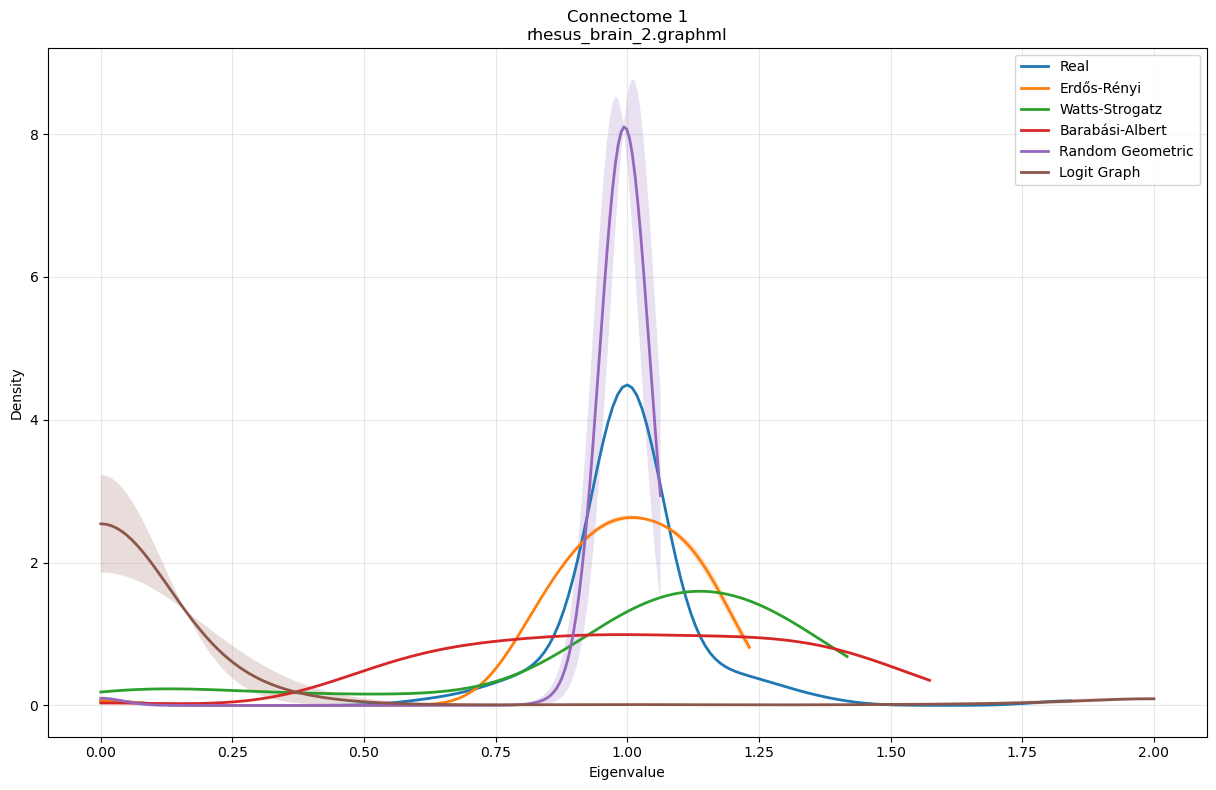

In [ ]:
# ----- Plotting Section -----
n_connectomes = 1
n_cols = 2
n_rows = (n_connectomes + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12 * n_cols, 8 * n_rows))
axes = axes.flatten()

model_families = {
    'ER': 'Erdős-Rényi',
    'GRG': 'Random Geometric', 
    'KR': 'Regular Random',
    'WS': 'Watts-Strogatz',
    'BA': 'Barabási-Albert',
    'LG': 'Logit Graph',
    'Real': 'Real'
}

# Plot 
for idx, (connectome_file, results) in enumerate(simulation_results):
    ax = axes[idx]
    for name, data in results[0].items():
        if name in model_families:
            label = model_families[name]
            ax.plot(data['x_range'], data['mean_curve'], label=label, linewidth=2)
            ax.fill_between(data['x_range'],
                            data['lower_ci'],
                            data['upper_ci'],
                            alpha=0.2)
    ax.set_title(f'Connectome {idx + 1}\n{results[1]}')
    ax.set_xlabel('Eigenvalue')
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(True, alpha=0.3)
for idx in range(len(simulation_results), len(axes)):
    fig.delaxes(axes[idx])
plt.tight_layout()
plt.show()
fig.savefig(f'../images/imgs_connectomes_spectra_kde/spectra_kde_{connectome_file}_d_{d}.png', bbox_inches='tight', dpi=300)


In [107]:
3213213

3213213